In [590]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

np.random.seed(123)

bike_rentals = pd.read_csv("bike_rental_hour.csv")
print(bike_rentals.head(n=6))
print(bike_rentals.info())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   
5        6  2011-01-01       1   0     1   5        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81     0.0000       3          13   16  
1           1  0.22  0.2727  0.80     0.0000       8          32   40  
2           1  0.22  0.2727  0.80     0.0000       5          27   32  
3           1  0.24  0.2879  0.75     0.0000       3          10   13  
4           1  0.24  0.2879  0.75     0.0000       0           1    1  
5           2  0.24  

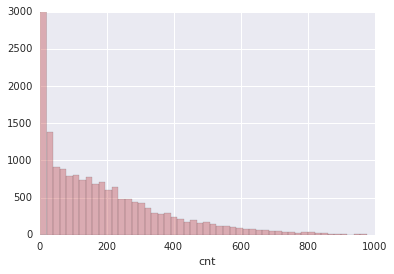

In [591]:
sns.set_color_codes()
sns.distplot(bike_rentals["cnt"], kde=False, color="r")
plt.show()

In [592]:

corr_matrix = bike_rentals.corr()
corr_cnt = np.abs(corr_matrix["cnt"])
corr_cnt.sort_values(inplace=True, ascending=False)
print(corr_cnt)


cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64


In [593]:
def assign_label(df):
    if df["hr"] > 6 and df["hr"] <= 12:
        return 1
    elif df["hr"] > 12 and df["hr"] <= 18:
        return 2
    elif df["hr"] > 18 and df["hr"] <= 24:
        return 3
    elif df["hr"] > 0 and df["hr"] <= 6:
        return 4

def assign_season(df):
    if df["mnth"] == 12 or (df["mnth"] >= 1 and df["mnth"] < 3):
        return 1
    elif df["mnth"] >= 3 and df["mnth"] < 6:
        return 2
    elif df["mnth"] >= 6 and df["mnth"] < 9:
        return 3
    elif df["mnth"] >= 9 and df["mnth"] <= 11:
        return 4
    
bike_rentals["time_label"] = bike_rentals.apply(assign_label, axis=1) 

bike_rentals["season_label"] = bike_rentals.apply(assign_season, axis=1)
columns.append("time_label")
columns.append("season_label")


missing time labels: 726


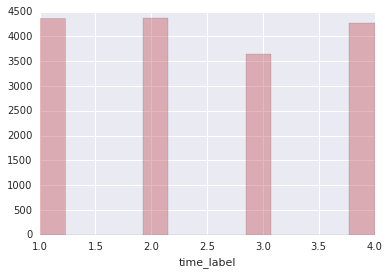

In [594]:
print('missing time labels:', bike_rentals["time_label"].isnull().sum())
time_labels = bike_rentals["time_label"].dropna()

sns.distplot(time_labels, kde=False, color="r")
plt.show()

In [595]:
bike_rentals = bike_rentals.dropna()
print(bike_rentals.info())
print(bike_rentals.shape)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16653 entries, 1 to 17378
Data columns (total 19 columns):
instant         16653 non-null int64
dteday          16653 non-null object
season          16653 non-null int64
yr              16653 non-null int64
mnth            16653 non-null int64
hr              16653 non-null int64
holiday         16653 non-null int64
weekday         16653 non-null int64
workingday      16653 non-null int64
weathersit      16653 non-null int64
temp            16653 non-null float64
atemp           16653 non-null float64
hum             16653 non-null float64
windspeed       16653 non-null float64
casual          16653 non-null int64
registered      16653 non-null int64
cnt             16653 non-null int64
time_label      16653 non-null float64
season_label    16653 non-null int64
dtypes: float64(5), int64(13), object(1)
memory usage: 2.5+ MB
None
(16653, 19)


In [596]:
def create_dummies(df, column):
    dummy_df = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummy_df], axis=1)
    df.drop(col, axis=1, inplace=True)
    return df

for col in ["time_label", "season_label", "weekday"]:
    bike_rentals = create_dummies(bike_rentals, col)


columns = bike_rentals.columns.tolist()

In [597]:
leftout_columns = ["cnt", "casual", "workingday", "dteday", "registered", "temp", "instant", "yr", "mnth", "hr", "time_label", "season_label", "weekday"]

predictor_columns = [col for col in columns if col not in leftout_columns]
target = "cnt"
bike_rentals_columns = predictor_columns.append(target)


corr_matrix = bike_rentals[predictor_columns].corr()
corr_cnt = np.abs(corr_matrix["cnt"])
corr_cnt.sort_values(inplace=True, ascending=False)
print(corr_cnt)


predictor_columns = corr_cnt[1:10].index.tolist()
target = "cnt"

cnt               1.000000
time_label_4.0    0.535941
time_label_2.0    0.420453
atemp             0.405355
hum               0.321931
season_label_1    0.232574
season            0.181559
season_label_3    0.154384
weathersit        0.146702
time_label_1.0    0.137591
windspeed         0.089449
season_label_4    0.077887
holiday           0.032143
weekday_0         0.032047
time_label_3.0    0.027676
weekday_4         0.017594
weekday_5         0.015724
weekday_1         0.011165
weekday_2         0.006415
weekday_3         0.005851
weekday_6         0.002203
season_label_2    0.001931
Name: cnt, dtype: float64


In [598]:
train_proportion = .8

train = bike_rentals.sample(frac=train_proportion, replace=False)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]


linear_model = LinearRegression()

linear_model.fit(train[predictor_columns], train[target])
predictions = linear_model.predict(test[predictor_columns])
rmse = np.sqrt(mean_squared_error(test[target], predictions))
print(rmse)


131.793308076


In [599]:
dtr = DecisionTreeRegressor(min_samples_leaf=5)

dtr.fit(train[predictor_columns], train[target])
predictions = dtr.predict(test[predictor_columns])
rmse_dec_tree = np.sqrt(np.mean((predictions - test["cnt"])**2))
print(rmse_dec_tree)

131.579918373


In [600]:
dtr = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=5)

dtr.fit(train[predictor_columns], train[target])
predictions = dtr.predict(test[predictor_columns])
rmse_dec_tree = np.sqrt(np.mean((predictions - test["cnt"])**2))
print(rmse_dec_tree)

131.543315065


In [601]:
rf_model = RandomForestRegressor(min_samples_leaf=5)

rf_model.fit(train[predictor_columns], train[target])
predictions = rf_model.predict(test[predictor_columns])
rmse_random_forest = np.sqrt(np.mean((predictions - test["cnt"])**2))
print(rmse_random_forest)

124.629274294


In [602]:
rf_model = RandomForestRegressor(min_samples_split=2, min_samples_leaf=5)

rf_model.fit(train[predictor_columns], train[target])
predictions = rf_model.predict(test[predictor_columns])
rmse_random_forest = np.sqrt(np.mean((predictions - test["cnt"])**2))
print(rmse_random_forest)

123.82859858


In [603]:
rf_model = RandomForestRegressor(min_samples_split=4, min_samples_leaf=10)

rf_model.fit(train[predictor_columns], train[target])
predictions = rf_model.predict(test[predictor_columns])
rmse_random_forest = np.sqrt(np.mean((predictions - test["cnt"])**2))
print(rmse_random_forest)

123.401794562


In [604]:
print(predictions[:10])
print("-"*10)
print(test["cnt"].iloc[:10])

[  11.83844081  214.83202462  204.72830098   91.01124754  126.25144464
   23.20424945   12.92600076  156.03482938  101.48672958  147.04144669]
----------
2      32
14    106
17     67
18     35
23     39
28      3
29      2
31      8
39     76
40     65
Name: cnt, dtype: int64
